In [45]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import numpy as np
%matplotlib inline

In [3]:
def plot_model_line(x, y, x_in, y_out, title="", xlabel="", ylabel="", length=7, height=5):
    fig, ax = plt.subplots(figsize=(length,height))
    if (title != ""):
        ax.set_title(title)
    if (xlabel != ""):
        ax.set_xlabel(xlabel)
    if (ylabel != ""):
        ax.set_ylabel(ylabel)
    ax.plot(x, y, c='r', marker="s", label='Input')
    #ax.bar(x, y, label='Input')
    ax.plot(x_in, y_out, label='Predicted')
    plt.legend(loc='upper left');
    plt.show()
    
def get_month_to_month_ridership_trends(station_data, months, station):
    month_key='Month'
    x_label ="index"
    y_label="Avg_Weekday"
    formula = "Avg_Weekday~index"
    coefs = []
    for month in months: 
        sample = station_data[station_data[month_key] == month]
        lm = smf.ols(formula = formula, data = sample).fit()
        predicted_ys = lm.predict()
        coefs.append(lm.params[x_label])
    
    return coefs
    
def interyear_ridership_trends(ridership_data, years, station):    
    year_key = "Year"
    formula = "Avg_Weekday~index"
    x_label ="index"
    y_label="Avg_Weekday"
    plt.figure(figsize=(20,5))
    height = 5
    length = 10
    for year in years:
        sample = ridership_data[ridership_data[year_key] == year]
        lm = smf.ols(formula = formula, data = sample).fit()
        predicted_ys = lm.predict()

        fig, ax = plt.subplots(figsize=(length,height))  
        ax.set_title("{}: Yearly Trends in Ridership {}".format(station, year))
        ax.plot(sample['yyyymm'], sample[y_label], c='r', marker="s", label=y_label)
        ax.plot(sample['yyyymm'], predicted_ys, label='Trend')
        plt.legend(loc='upper left');
        plt.show()

def overall_trend(ridership_data, station): 
    formula = "Avg_Weekday~index"
    x_label = "yyyymm"
    y_label = "Avg_Weekday"

    lm = smf.ols(formula = formula, data = ridership_data).fit()
    predicted_ys = lm.predict()
    plot_model_line(ridership_data[x_label], ridership_data[y_label], 
                    ridership_data[x_label], predicted_ys, 
                    length=20, height=5, title="{}: PATH Ridership Trend".format(station))
    print("{}: Ridership Growth Trend in [201701 -> 201809]: {}".format(station, lm.params['index']))


In [4]:
path_ridership = pd.read_csv("../data/path_ridership_data/path_ridership.csv", thousands=',')
path_ridership.head()

,Station,Year,Month,Month_Totals,Avg_Weekday,Avg_Saturday,Avg_Sunday,Avg_Holiday
0,Journal Square,2019,9,724999,29541,16058,11932,10293
1,Grove Street,2019,9,566317,23338,12448,8701,6259
2,Exchange Place,2019,9,414785,18658,4948,3741,3123
3,Pavonia/ Newport,2019,9,474542,20037,8940,6552,5276
4,Journal Square,2019,8,717286,27074,15231,11373,0


In [5]:
stations = path_ridership.Station.unique()
months = path_ridership.Month.unique()
years = path_ridership.Year.unique()
stations.sort(), months.sort(), years.sort()

print(len(stations), len(months), len(years))

4 12 3


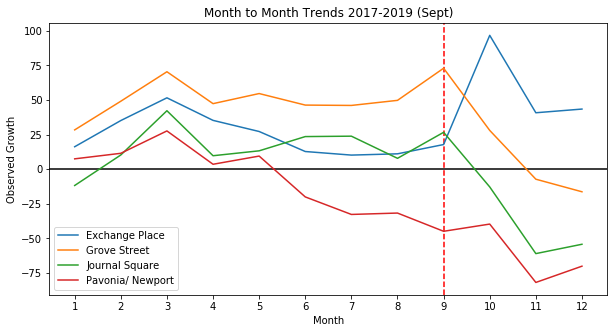

In [6]:
# overall_trend(ridership_data, station)

monthly_data = {}

for station in stations:
    
    sample_gs = path_ridership[(path_ridership['Station'] == station) ].copy()
    sample_gs = sample_gs.sort_values(['Year', 'Month'], ascending=[True, True])

    sample_gs['yyyymm'] = sample_gs['Year'].apply(str) + sample_gs['Month'].apply(lambda x: str(x).zfill(2))
    sample_gs.reset_index(level=0, inplace=True)
    sample_gs['index'] = sample_gs.index

    growth_per_month = get_month_to_month_ridership_trends(sample_gs, months, station)
    monthly_data[station] = growth_per_month

plt.figure(figsize=(10,5))
plt.title("Month to Month Trends 2017-2019 (Sept)")
plt.xticks(months)
plt.xlabel('Month')
plt.ylabel("Observed Growth")
plt.axvline(x=9, color='r', linestyle='--')
plt.axhline(y=0, color='k')
for station in stations:
    coefs = monthly_data[station]
    plt.plot(months, coefs, label=station)
plt.legend(loc='lower left')
plt.show()

In [7]:
### Now lets look at the hourly trends 

In [8]:
## get data and get unique values of months 
years = [2017, 2018, 2019]
stations = ['Journal Square', 'Grove Street', 'Exchange Place', 'Newport']

path_hourly_ridership = pd.DataFrame()
for year in years: 
    temp = pd.read_csv("../data/path_ridership_data/{}-PATH-hourly-Ridership-Report.csv".format(year), thousands=',')
    temp['year'] = year
    path_hourly_ridership = path_hourly_ridership.append(temp)

months = path_ridership.Month.unique()
months.sort()

path_hourly_ridership.head()

,Hour,Avg Weekday Entry,Avg Saturday Entry,Avg Sunday Entry,Avg Weekday Exit,Avg Saturday Exit,Avg Sunday Exit,Avg Holiday Entries,Avg Holiday Exits,month,station,year
0,12:00:00 AM,36,150,156,8,21,30,47,7,1,Christopher St.,2017
1,1:00:00 AM,19,96,145,9,29,30,36,9,1,Christopher St.,2017
2,2:00:00 AM,10,65,111,4,16,18,23,8,1,Christopher St.,2017
3,3:00:00 AM,9,46,72,7,12,19,16,2,1,Christopher St.,2017
4,4:00:00 AM,8,28,33,7,6,8,11,6,1,Christopher St.,2017


In [9]:
## filter for stations we're interested in 
path_hourly_ridership = path_hourly_ridership[path_hourly_ridership['station'].isin(stations)]
## format time column
path_hourly_ridership['Hour'] = pd.to_datetime(path_hourly_ridership['Hour']).dt.strftime('%H:%M:%S')
path_hourly_ridership.head()

,Hour,Avg Weekday Entry,Avg Saturday Entry,Avg Sunday Entry,Avg Weekday Exit,Avg Saturday Exit,Avg Sunday Exit,Avg Holiday Entries,Avg Holiday Exits,month,station,year
2304,00:00:00,39,76,84,351,664,547,49,453,1,Journal Square,2017
2305,01:00:00,23,42,51,234,330,717,22,270,1,Journal Square,2017
2306,02:00:00,30,32,49,118,251,404,21,137,1,Journal Square,2017
2307,03:00:00,55,37,44,90,237,343,37,94,1,Journal Square,2017
2308,04:00:00,193,86,60,119,195,274,112,94,1,Journal Square,2017


In [11]:
grouped_hr_data = path_hourly_ridership[path_hourly_ridership['month'].isin([6,7,8,9])].groupby(['station','Hour'], as_index=False).mean()

hours = list(grouped_hr_data.Hour.unique())
morning_rush_hours = hours[6:11]
evening_rush_hours =  hours[16:21]

print(morning_rush_hours)
print(evening_rush_hours)

['06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00']
['16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00']


In [101]:
rush_hour_summaries = pd.DataFrame(columns=['station','avg_morn_rush', 'avg_eve_rush'])

values = []
for station in stations:
    avg_total_morning_entry = grouped_hr_data[(grouped_hr_data.Hour.isin(morning_rush_hours))
                     &(grouped_hr_data.station==station)
                   ]['Avg Weekday Entry'].sum()
    avg_total_evening_exit = grouped_hr_data[(grouped_hr_data.Hour.isin(evening_rush_hours))
                 &(grouped_hr_data.station==station)
               ]['Avg Weekday Exit'].sum()
    temp = {'station':station,'avg_morn_rush': avg_total_morning_entry,'avg_eve_rush':avg_total_evening_exit}
    values.append(temp)

rush_hour_summaries = pd.DataFrame(values)
rush_hour_summaries

,station,avg_morn_rush,avg_eve_rush
0,Journal Square,16656.090909,15779.818182
1,Grove Street,13796.181818,13047.909091
2,Exchange Place,7286.272727,6615.909091
3,Newport,8422.272727,8705.454545


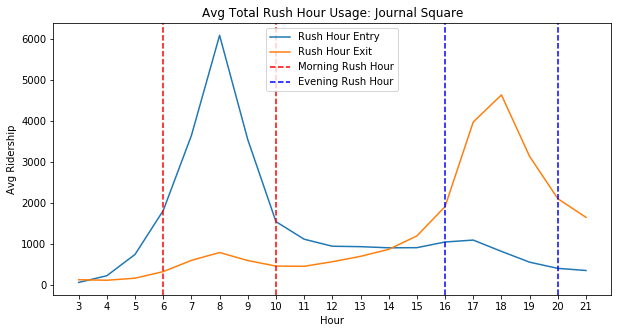

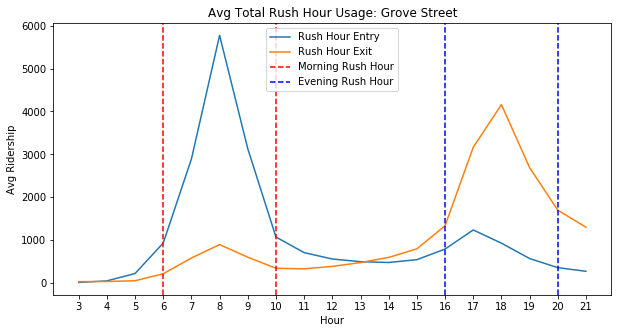

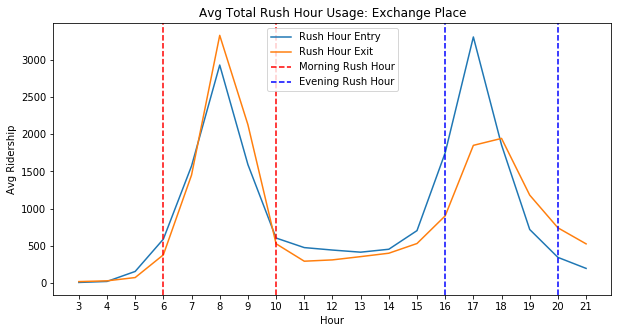

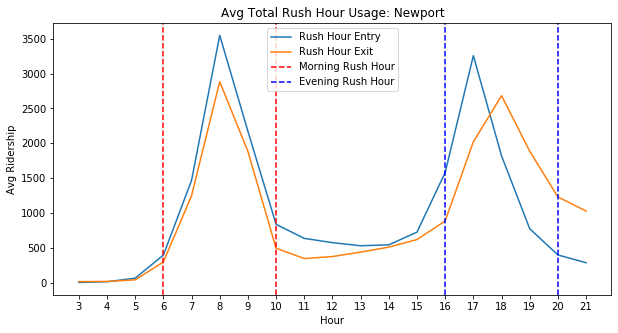

In [100]:
desired_range = hours[3:22]
xlabels = np.arange(3,22,1)
for station in stations: 
    plt.figure(figsize=(10,5))
    plt.title("Avg Total Rush Hour Usage: {}".format(station))
    plt.xticks(xlabels)
    plt.xlabel('Hour')
    plt.ylabel("Avg Ridership")
    plt.plot(xlabels, grouped_hr_data[(grouped_hr_data['station'] ==station)&
                                      (grouped_hr_data['Hour'].isin(desired_range))]
             ['Avg Weekday Entry'], label='Rush Hour Entry')
    plt.plot(xlabels, grouped_hr_data[(grouped_hr_data['station'] ==station)&
                                      (grouped_hr_data['Hour'].isin(desired_range))]
             ['Avg Weekday Exit'], label='Rush Hour Exit')
    plt.axvline(x=6, color='r', linestyle='--', label='Morning Rush Hour')
    plt.axvline(x=10, color='r', linestyle='--')
    plt.axvline(x=16, color='b', linestyle='--', label='Evening Rush Hour')
    plt.axvline(x=20, color='b', linestyle='--')
    plt.legend(loc='upper center')
    plt.show()

In [15]:
avg_total_commuters = path_hourly_ridership[(path_hourly_ridership['Hour'].isin(morning_rush_hours))
                                         ].groupby(['station','year','month']).sum()
avg_total_commuters.rename(columns={"Avg Weekday Entry": "AvgTotalMorningRiders"}, inplace=True)

avg_total_commuters["AvgTotalEveningRiders"] = path_hourly_ridership[(path_hourly_ridership['Hour'].isin(evening_rush_hours))
                                                                    ].groupby(['station','year','month']).sum()["Avg Weekday Exit"]
avg_total_commuters.drop(columns=['Avg Saturday Entry', 'Avg Sunday Entry',
                                  'Avg Saturday Exit', 'Avg Sunday Exit', 'Avg Holiday Entries',
                                  'Avg Holiday Exits', 'Avg Weekday Exit'], inplace=True)

avg_total_commuters[avg_total_commuters.index.get_level_values('station') == 'Exchange Place']
avg_total_commuters.head()

AvgTotalMorningRiders  AvgTotalEveningRiders
station        year month                                              
Exchange Place 2017 1                       6289                   5797
                    2                       6220                   5661
                    3                       6223                   5725
                    4                       6535                   6034
                    5                       6696                   6142

['1/17', '2/17', '3/17', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17', '10/17', '11/17', '12/17', '1/18', '2/18', '3/18', '4/18', '5/18', '6/18', '7/18', '8/18', '9/18', '10/18', '11/18', '12/18', '1/19', '2/19', '3/19', '4/19', '5/19', '6/19', '7/19', '8/19']
16656.090909090908


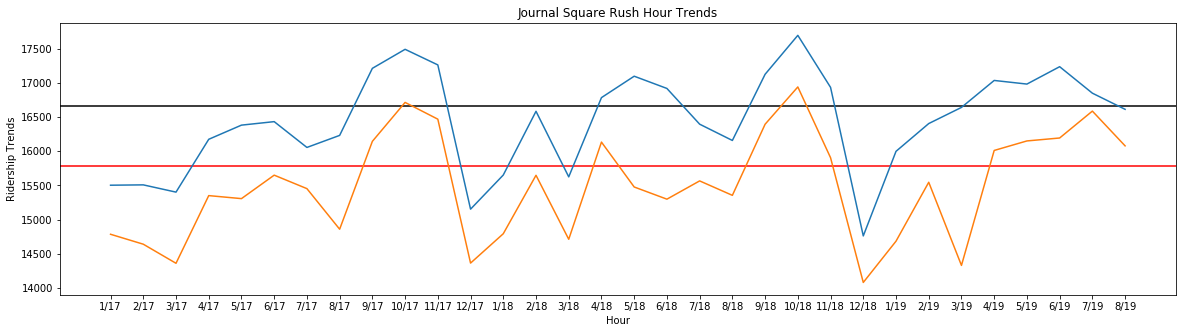

13796.181818181818


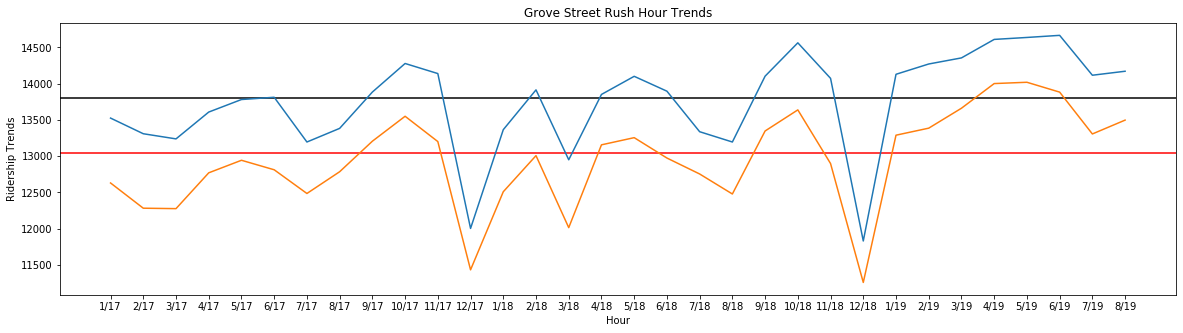

7286.272727272728


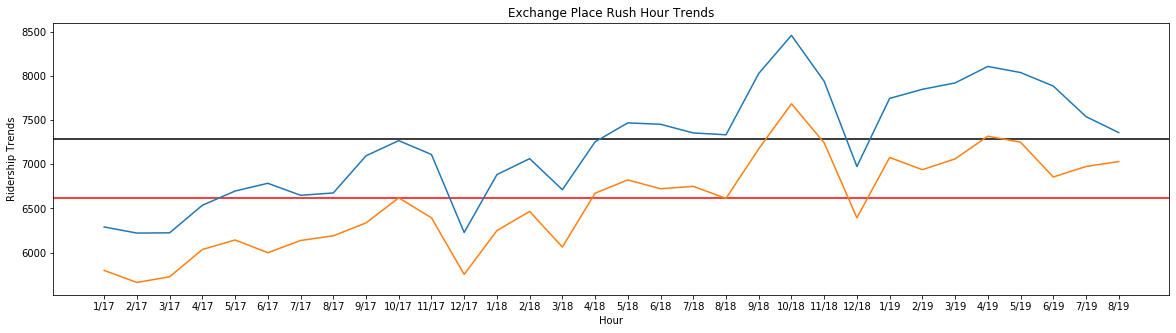

8422.272727272726


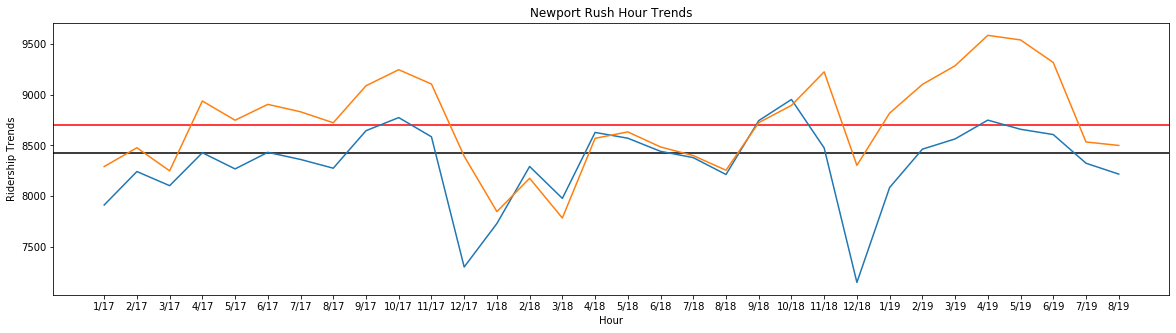

In [42]:


dates = []
for year in years:
    for month in months:
        dates.append("{}/{}".format(month,str(year)[2:]))

print(dates[:-4])
daterange = dates[:-4]
for station in stations:
    plt.figure(figsize=(20,5))
    plt.title("{} Rush Hour Trends".format(station))
    plt.xlabel('Hour')
    plt.ylabel("Ridership Trends")
    
    print(rush_hour_summaries[rush_hour_summaries['station'] == station]['avg_morn_rush'].values[0])
    
    plt.axhline(y=rush_hour_summaries[rush_hour_summaries['station']==station]['avg_morn_rush'].values[0], color='k')
    plt.axhline(y=rush_hour_summaries[rush_hour_summaries['station']==station]['avg_eve_rush'].values[0], color='r')
    
    plt.plot(daterange, avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == station)]
             ['AvgTotalMorningRiders'], label='{} Morning Entry'.format(station))
    plt.plot(daterange, avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == station)]
             ['AvgTotalEveningRiders'], label='{} Morning Exit'.format(station))
    plt.show()


Text(0, 0.5, 'Residual')

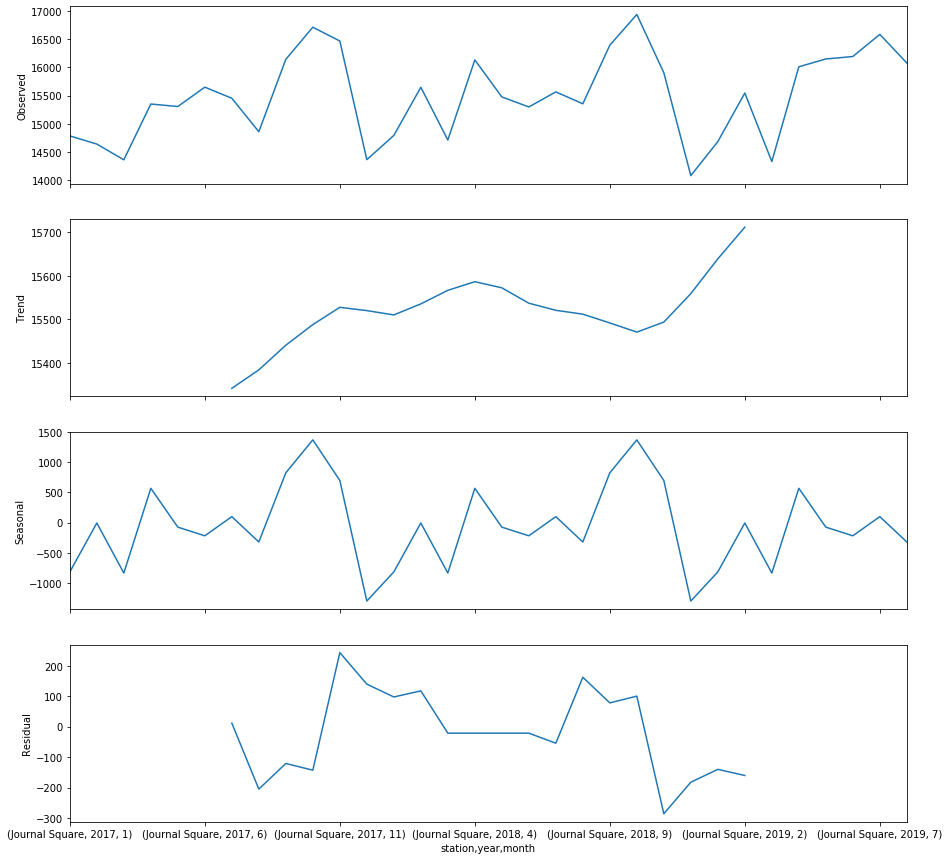

In [87]:
res = sm.tsa.seasonal_decompose(
    avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == 'Journal Square')
                       ]['AvgTotalEveningRiders'],model='additive', freq=12)
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,15))
res.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')